In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("biological_data.csv", index_col=0)
df.head()

,Y,X1,X2,X3,X4,X5,X6
0,5000,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,82.277778,106.555556,-4.522222e+01
1,138,human,XSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQWMFGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAA...,79.444444,103.444444,-4.400000e+01
2,5000,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,79.444444,103.444444,-4.400000e+01
3,5000,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,85.444444,108.888889,-9.666667e+00
4,5000,human,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,50.611111,85.444444,1.233581e-15


The goal is to make a model for estimating Y given X1-X6. X1 appears to label what kind of animal the data came from, X2 and X3 are protein sequencing data, and X4-X6 appears to be continuous numerical data.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 1994
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       1995 non-null   int64  
 1   X1      1995 non-null   object 
 2   X2      1995 non-null   object 
 3   X3      1995 non-null   object 
 4   X4      1995 non-null   float64
 5   X5      1995 non-null   float64
 6   X6      1995 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 124.7+ KB


There doesn't appear to be any missing values in any of the columns (1995 non-null). Next lets look for duplicated data.

In [3]:
print(f"There are {df[df.duplicated()].__len__()} duplicated datapoints")
print(df[df.duplicated()].describe())
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

print(f"New size of dataset: {len(df)}")

There are 34 duplicated datapoints
                Y          X4          X5         X6
count   34.000000   34.000000   34.000000  34.000000
mean    86.205882   86.210784  110.297386 -31.428105
std    116.926752   12.319902    8.672696  21.101170
min      1.000000   56.500000   91.555556 -82.111111
25%      6.250000   80.611111  105.805556 -43.194444
50%     37.000000   87.750000  110.277778 -27.166667
75%    120.250000   92.625000  116.805556 -22.361111
max    486.000000  111.888889  127.444444  19.444444
New size of dataset: 1961


Since the number of duplicated datapoints was small, we can remove them without thinking too much about it. We could try to find some statistical difference between the duplicated points and the rest of the data - but the only think I found noticable was that the duplicated points all had lower values of Y (mean of 86 compared to ~6000 for the full dataset).

Next lets look at the number of unique values for the columns

In [4]:
for column in df.columns:
    print(f"{column}: nunique - {df[column].nunique()}")

Y: nunique - 557
X1: nunique - 1
X2: nunique - 10
X3: nunique - 9
X4: nunique - 680
X5: nunique - 374
X6: nunique - 882


The value for X1 is "human" for all rows, so lets drop that column.

In [5]:
df = df.drop(["X1"], axis=1);

Now, we'll explore each of the variables in the dataset one by one - starting with the protein sequences.

## Protein sequences (X2, X3)

The protein sequencing data (X2 and X3), have 10 and 9 unique sequences each. Do they have any sequences in common?

In [6]:
print(f"{df['X2'].nunique()} unique sequences in X2:")
print(df["X2"].value_counts())

print(f"\n{df['X3'].nunique()} unique sequences in X3:")
print(df["X3"].value_counts())

10 unique sequences in X2:
XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSED    509
XSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEA    283
XSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSED    232
XSHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQTDRVNLRKLRGYYNQSEA    181
XSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEA    172
XSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEA    171
XSHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEA    162
XSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSED    142
XSHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEA     90
XSHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSED 

We can quickly see that all sequences in X2 start with the amino acids XSHS, while the sequences in X3 starts with either XSHT or XSHI - so there are no common sequences between X2 and X3. We also see that the sequences in X2 consists of 90 amino acids, while the sequences in X3 consists of 92 amino acids. The unique sequences are not uniformely distributed - some sequences are much more common than others in the dataset.

What is the correlation between sequences in X2 and X3? Are there some pairs of sequences that are more common than others? Lets map each unique sequence to a label and find out.

In [7]:
# Create a dict mapping from sequence to labels
sequences = df["X2"].unique()
seq_to_label = {sequences[n]:n for n in range(len(sequences))}

sequences = df["X3"].unique()
seq_to_label.update({sequences[n]:n for n in range(len(sequences))})

# Load the data into a pandas dataframe
data_encoded = pd.DataFrame({
    'X2': df["X2"],
    'X3': df["X3"]
})

# Encode the sequences as labels using the dict mapping
data_encoded = data_encoded.applymap(lambda seq: seq_to_label[seq])

# Compute the pair frequency
pair_freq = data_encoded.groupby(['X2', 'X3']).size().reset_index(name='freq')

    X2  X3  freq
0    0   0   509
1    1   1   283
2    2   2   232
3    3   3    19
4    4   4   162
5    5   5   171
6    6   6   142
7    7   5    87
8    7   8     3
9    8   7   181
10   9   2   172


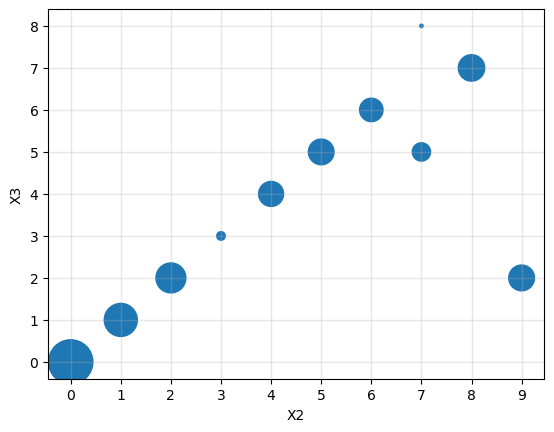

In [8]:
import matplotlib.pyplot as plt
plt.scatter(x=pair_freq["X2"], y=pair_freq["X3"], s=pair_freq["freq"]*2);
plt.xlabel("X2"), plt.ylabel("X3");
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(0, 9, 1))
plt.grid(alpha=0.3, linewidth=1)
print(pair_freq)

We see that there is a high correlation between the unique sequences in X2 and X3. Most of the sequences X2 always comes paired with one specific sequence in X3 (and vice versa). \
The only exception is found for the following sets:

- sequence 2 in X3: 2 or 9 in X2
- sequence 5 in X3: 5 or 7 in X2
- sequence 7 in X2: 5 or 8 in X3 (only 3 datapoints with the 7,8 tuple)

Now when a sequence in X2 is perfectly correlated with a sequence in X3 - there is no predictive power in including both sequences, and we could choose to just keep one of them. \
The problem with choosing to keep just one of the sequences comes from the subset of the data where there is variation in the pairing. \
It is possible the differences comes from variations in the sequences that are not biologically meaningful, and we can get a quick feel for that by examining the preditive power of the tuples.

In [9]:
# create a copy of the dataframe to avoid modifying the original dataframe
encoded_df = df.copy()

# encode sequences in columns to labels
encoded_df['X2_encoded'], uniques_X2 = pd.factorize(df['X2'])
encoded_df['X3_encoded'], uniques_X3 = pd.factorize(df['X3'])

In [10]:
value = 5 # the value of X2 you want to filter for
subset_df = encoded_df[encoded_df['X3_encoded'] == value]

c:\Users\vesor\Anaconda3\envs\detectron2\lib\site-packages\pandas\plotting\_matplotlib\misc.py:101: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[j])
c:\Users\vesor\Anaconda3\envs\detectron2\lib\site-packages\pandas\plotting\_matplotlib\misc.py:102: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(boundaries_list[i])
c:\Users\vesor\Anaconda3\envs\detectron2\lib\site-packages\pandas\plotting\_matplotlib\misc.py:92: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(boundaries_list[i])


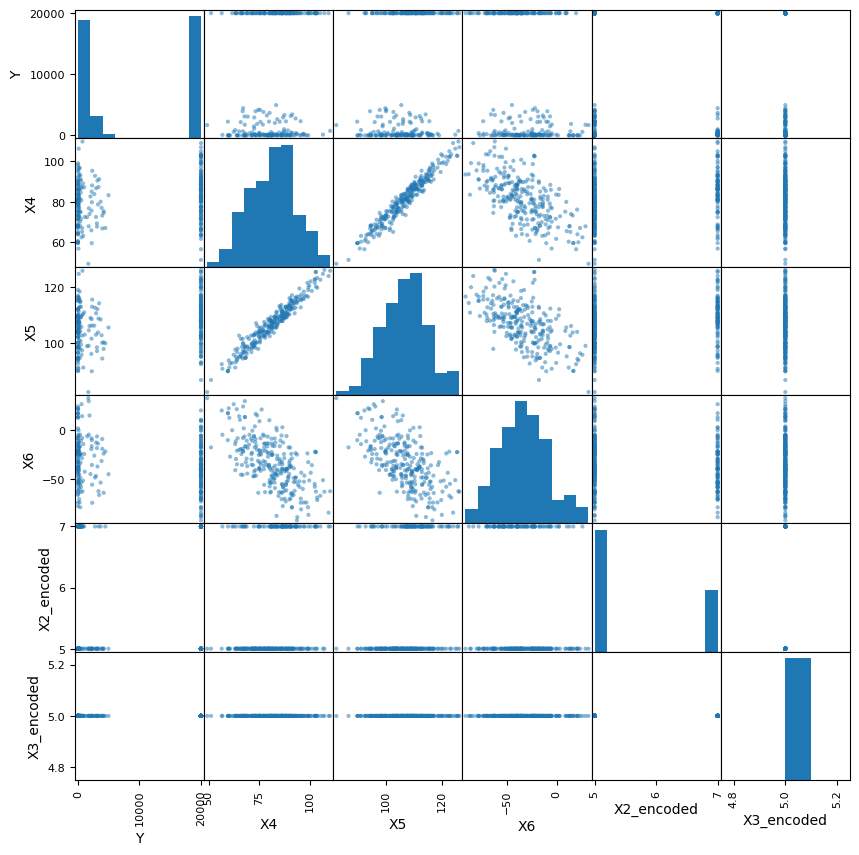

In [11]:
pd.plotting.scatter_matrix(subset_df, figsize=(10,10));

Going through the relevant sequences, there doesn't seem to be an obvious correlation between the pairs of sequences for the three cases mentioned above. \
Therefore the null hypothesis could be that using both X2 and X3 will result in the same predictive power as using just X2. I chose X2 because I can then split the (2, 2) and (9,2) point into 2 and 9. \
We could then train models using both sequences and only one, and compare the final performance.

Moving on from the categorical encoding of full sequences, lets now take a look at the variation in amio acids:

In [12]:
print(f"unique AA in X2: {sorted(list(set(df['X2'].unique().sum())))}")
print(f"unique AA in X3: {sorted(list(set(df['X3'].unique().sum())))}")

unique AA in X2: ['A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']
unique AA in X3: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']


There are 20 unique amino acids in the sequences of X2, while 21 in X3 (C in addition).\
Next, lets look at which positions the sequences differ.

In [13]:
sequences = df["X2"].unique()
length = len(sequences[0])
num_seqs = len(sequences)

X2_var_dict = {}
# Compare sequences
for i in range(length):
    amino_acids = set(seq[i] for seq in sequences)
    if len(amino_acids) > 1:
        print(f"Position {i+1}: {' '.join(amino_acids)}")
        X2_var_dict[i+1] = list(amino_acids)

Position 9: S Y D
Position 11: S A
Position 14: W R
Position 21: H R
Position 24: S A
Position 35: R Q
Position 49: E A
Position 66: N K
Position 73: T A
Position 77: S N
Position 80: N K
Position 90: A D


In [14]:
sequences = df["X3"].unique()
length = len(sequences[0])
num_seqs = len(sequences)

# Compare sequences
X3_var_dict = {}
for i in range(length):
    amino_acids = set(seq[i] for seq in sequences)
    if len(amino_acids) > 1:
        print(f"Position {i+1}: {' '.join(amino_acids)}")
        X3_var_dict[i+1] = list(amino_acids)

Position 4: T I
Position 5: L I
Position 7: W R
Position 9: S F Y
Position 13: L V
Position 23: H Y
Position 24: N D
Position 26: L S F Y
Position 48: T K
Position 57: L W
Position 62: E A T
Position 66: L W R
Position 73: T L
Position 83: E K
Position 85: R G
Position 87: E K


We see that there are only a few positons where the sequences vary (12 and 16 for X2 and X3).

To prepare the sequences for machine learning we need some way to transform the sequence strings to numerical values. Based on the exploration we have done so far a few ways to encode the data comes to mind:
* Since there only are a few unique sequences we could give **each sequence their own category** and use one-hot-encoding. \
The advantage of this method is that it is simple and gives us a low dimensional dataset that is easy to work with. \
The downside is that you ignore the specific variation within sequences

* Another option would be to **categoricaly encode the 11 unique pairs of X2 and X3 sequences**. \
The advantages are the same as with the previous method - further reducing the dimension of the data.\
The disadvantage is that you lose the relative importance of X2 and X3.

* Since the sequences consist of 21 different amino-acids, we could use **one hot encoding on the different acids**, and then stack or contactenate them ending up with a 21xL array, where L is the length of the sequence.
The advantage here is that you preserve the full information of the data\
The downside is that it results in high dimensional vectors (20*90 = 1800) which are sparse and similar due to the similarity of the original sequences.

* Another option would be to **encode just the variation of the few positions that are not conserved**\
The advantage here is that you get dimensional reduction of the original data, that captures much of the variance of the data.\
The downside is that it can lead to loss of information if the conserved regions are important for the protein's function.

* A fourth and final option would be to use a **feature vector from a neural network** that is trained on some protein sequencing task (eg ProtBert model https://huggingface.co/Rostlab/prot_bert) .\
The advantage is that the network have been trained on a much larger dataset that we have, the representation of the sequence in the feature space of the network should hold discriminative properties. \
A downside is that the network have been trained on a large amount of varied proteins, which if our proteins are a small (or non-existent) subset of the training data the representation can be either less meaningful, or the sequences can all have very similar vectors which will reduce the discriminative properties.

## Numerical variables (X4, X5, X6)

First we encode the X2 and X3 columns to the 10 and 9 categorical indices

In [15]:
# create a copy of the dataframe to avoid modifying the original dataframe
encoded_df = df.copy()

# encode sequences in column X2 to labels
encoded_df['X2_encoded'], uniques_X2 = pd.factorize(df['X2'])

# encode sequences in column X3 to labels
encoded_df['X3_encoded'], uniques_X3 = pd.factorize(df['X3'])

Then we encode the 11 unique pairs of the X2 and X3 sequences

In [16]:
encoded_df['X2_X3_encoding'] = pd.factorize(list(zip(encoded_df['X2_encoded'], encoded_df['X3_encoded'])))[0]

C:\Users\vesor\AppData\Local\Temp\ipykernel_9028\3302129362.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(encoded_df.corr())


                       Y        X4        X5        X6  X2_encoded  \
Y               1.000000  0.032278  0.033839 -0.074202   -0.076031   
X4              0.032278  1.000000  0.978527 -0.571391   -0.015751   
X5              0.033839  0.978527  1.000000 -0.498001   -0.034047   
X6             -0.074202 -0.571391 -0.498001  1.000000   -0.070613   
X2_encoded     -0.076031 -0.015751 -0.034047 -0.070613    1.000000   
X3_encoded      0.012011 -0.010439 -0.020492 -0.068110    0.781451   
X2_X3_encoding -0.076584 -0.016028 -0.033913 -0.069058    0.999324   

                X3_encoded  X2_X3_encoding  
Y                 0.012011       -0.076584  
X4               -0.010439       -0.016028  
X5               -0.020492       -0.033913  
X6               -0.068110       -0.069058  
X2_encoded        0.781451        0.999324  
X3_encoded        1.000000        0.782863  
X2_X3_encoding    0.782863        1.000000  


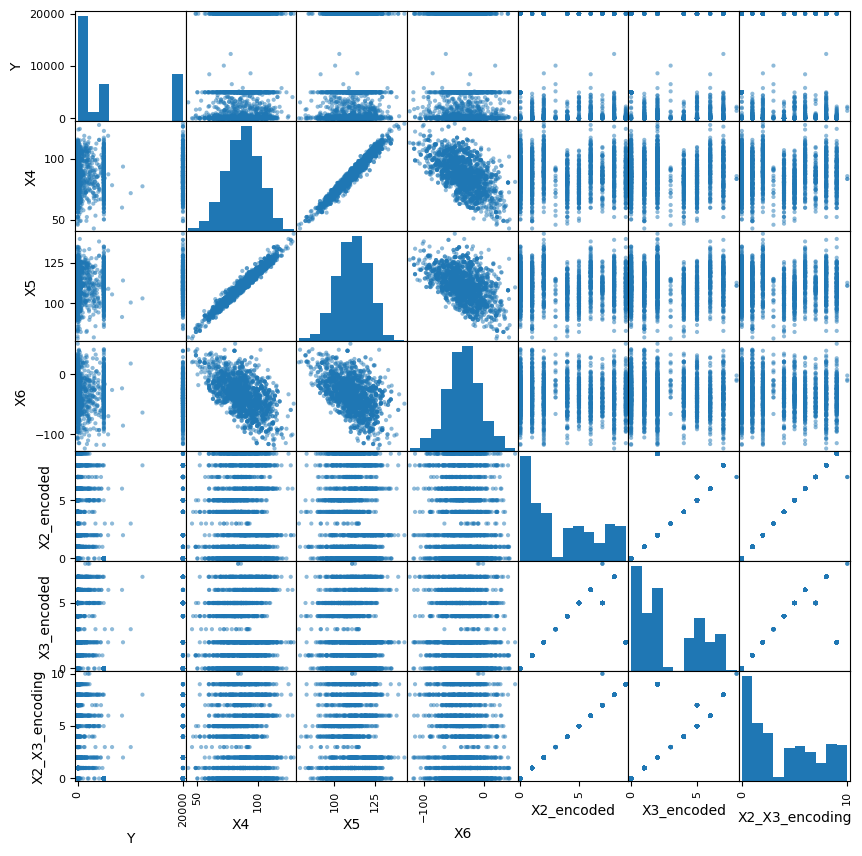

In [17]:
print(encoded_df.corr())
pd.plotting.scatter_matrix(encoded_df, figsize=(10,10));

X4, X5, and X6 all seem to be approx gaussian distributed. \
We see that X4 and X5 is highly correlated with each other, and both are moderatly negatively correlated with X6. \
Unfortunately none of the variables seems to be particularly correlated with Y. 

20000    465
5000     340
1        154
2         33
3         20
        ... 
3106       1
2634       1
5799       1
798        1
1465       1
Name: Y, Length: 557, dtype: int64


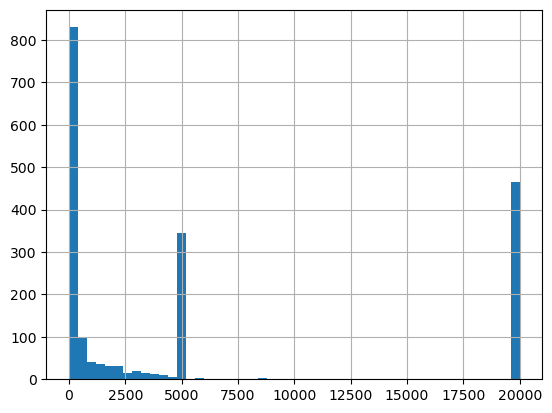

In [18]:
encoded_df["Y"].hist(bins=50)
print(encoded_df["Y"].value_counts())

Y seems to be an approximately log-normal distribution, with many counts of 20 000 and 5000. \
Here it makes sense to perform a log transformation of the data to reduce the range of Y values.

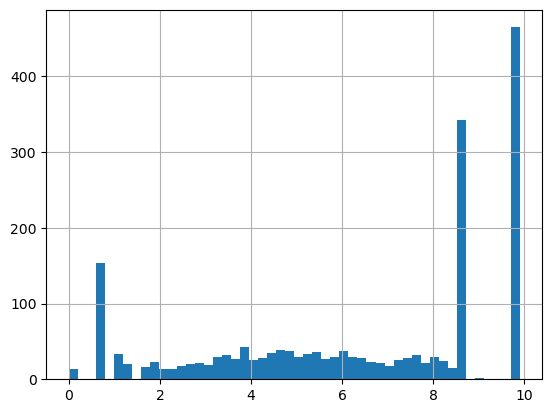

In [19]:
np.log(encoded_df["Y"]+1).hist(bins=50);
encoded_df["log(Y+1)"] = np.log(encoded_df["Y"]+1)

In [20]:
encoded_df[encoded_df["Y"] == 5000.]["X2_X3_encoding"].value_counts()

0    340
Name: X2_X3_encoding, dtype: int64

In [21]:
encoded_df[encoded_df["Y"] == 20000.]["X2_X3_encoding"].value_counts()

0    140
5     74
2     72
8     71
7     44
4     30
1     15
9     10
6      9
Name: X2_X3_encoding, dtype: int64

Looking closer at the data for Y = 5000 and Y = 20 0000:
* we see that all datapoints for Y = 5000 consists of the same pair of X2 and X3 sequences (0,0), but (0, 0) also appears for other values of Y 
* for Y = 20 000 there is a more uniform distribution of sequence pairs (but still biased towards (0, 0)) 

The distribution of Y in the dataset is highly imbalanced with the majority of samples taking on the values 20 000 (23%) 5000 (17%) and 1 (8%). \
Imbalanced datasets can make it challenging for machine learning algorithms to accurately predict the minority values. \
Here are a few ways to deal with imbalanced datasets:

* **Undersampling or oversampling**: You can either randomly undersample the majority values or oversample the minority values to balance the dataset. Undersampling randomly removes some samples from the majority values, while oversampling creates synthetic samples for the minority values.

* **Cost-sensitive learning**: You can assign a higher misclassification cost to the minority values and a lower misclassification cost to the majority values. This will make the algorithm focus more on correctly classifying the minority values. 

* **Ensembling methods**: You can use ensembling methods, such as bagging and boosting, to improve the prediction accuracy for the minority values. 

It's important to keep in mind that imbalanced data is a common problem in regression tasks, and it's not always necessary to balance the dataset. It's often more important to **evaluate the performance** of the model on the under-represented classes and make sure it's not biased towards the majority class.

For the purposes of this exercise and in the interest of time I will choose to perform a simple **frequency weighting** for some of the models, and ignore the imbalance for others. 

In [22]:
freq = encoded_df["Y"].value_counts()

weights = 1 / freq

encoded_df["Y_weights"] = encoded_df["Y"].map(weights)

print(encoded_df[["Y", "Y_weights"]])

         Y  Y_weights
0     5000   0.002941
1      138   0.500000
2     5000   0.002941
3     5000   0.002941
4     5000   0.002941
...    ...        ...
1956   761   1.000000
1957  1215   1.000000
1958  2238   1.000000
1959  1981   1.000000
1960  1465   1.000000

[1961 rows x 2 columns]


## Final preprocessing and data split

Here is a list of all the preprocessing we perform:

* Categorical encoding of unique sequences
* Categorical encoding of unique X2-X3 sequence pairs
* Encoding of all variations within sequences
* Pretrained network feature vector
* To remove the correlation between X4, X5 and X6, we will perform a PCA and project the datapoints into one or two dimensions which are orthogonal and maximizes variance.
* Log transform of Y

#### PCA

In [23]:
from sklearn.decomposition import PCA

pca_df = encoded_df.copy()
pca_df = pca_df[["X4","X5","X6"]]

pca_df=(pca_df-pca_df.mean())/pca_df.std()

pca = PCA(n_components=2)
pca.fit(pca_df);
pca.explained_variance_ratio_


array([0.79672598, 0.1974157 ])

In [24]:
pca_df["PCA1"], pca_df["PCA2"] = pca.fit_transform(pca_df).T
encoded_df["PCA1"] = pca_df["PCA1"].copy()
encoded_df["PCA2"] = pca_df["PCA2"].copy()

With an explained variance ratio of 0.99, we have reduced the three correlated variables to two orthogonal ones.

#### Pretrained network feature vector encodings

In [25]:
from transformers import BertModel, BertTokenizer
import re
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert")

c:\Users\vesor\Anaconda3\envs\detectron2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a mo

In [26]:
import torch

seq_to_vec = {}

with torch.no_grad():
    for seq in seq_to_label.keys():
        encoded_input = tokenizer(" ".join(seq), return_tensors='pt')
        output = model(**encoded_input)
        seq_to_vec[seq] = output.pooler_output.detach().numpy()

We save the feature vectors from the pretrained network for both the X2 and X3 sequences. 

In [27]:
encoded_df["X2_vec"] = encoded_df[["X2"]].applymap(lambda x: seq_to_vec[x])
encoded_df["X3_vec"] = encoded_df[["X3"]].applymap(lambda x: seq_to_vec[x])

Since we'll also perform binary classification of Y with the treshold of Y = 50, we save the binary classification in a column as well.

In [28]:
encoded_df["Y_binary"] = (encoded_df["Y"] > 50)
encoded_df["Y_binary"].value_counts()

True     1472
False     489
Name: Y_binary, dtype: int64

The final point on our preprocessing agenda is to split the data into a training, validation and test set.\
Actually since this is just an exercise and the final results is not important I will not hold out data for final testing, but just use training and validation. \
Using the same excuse as before about the interest of time, I will choose a simple random 5-fold split and perform 5-fold cross validation for evaluation of the models.

In [29]:
encoded_df["fold"] = np.random.randint(0, 5, len(encoded_df))

Next, lets also perform the sequence variation encoding

In [30]:
# Define a function to one-hot encode a sequence at the specified positions
def encode_sequence(sequence, positions):
    # Initialize an empty array to store the one-hot encoded features
    features = np.zeros((len(positions), len(max(positions.values(), key=len))))
    # Loop over the positions and their possible variations
    for i, (pos, vars) in enumerate(positions.items()):
        # Find the index of the variation in the list of possible variations
        j = vars.index(sequence[pos-1])
        # Set the corresponding feature to 1
        features[i,j] = 1
    # Flatten the array and return it as a numpy array
    return features.flatten().tolist()

# Create a new column to store the encodings
encoded_df['X2_var_encoding'] = None
encoded_df['X3_var_encoding'] = None

# Iterate over the sequences in the dataframe and apply the encoding function

for i, sequence in enumerate(encoded_df['X2']):
    encoding = encode_sequence(sequence, positions=X2_var_dict)
    # Store the encoding in the new column
    encoded_df.at[i, 'X2_var_encoding'] = encoding

for i, sequence in enumerate(encoded_df['X3']):
    encoding = encode_sequence(sequence, positions=X3_var_dict)
    # Store the encoding in the new column
    encoded_df.at[i, 'X3_var_encoding'] = encoding

Lets take a final look at our dataset to check if everything looks alright

In [31]:
encoded_df.head()

,Y,X2,X3,X4,X5,X6,X2_encoded,X3_encoded,X2_X3_encoding,log(Y+1),Y_weights,PCA1,PCA2,X2_vec,X3_vec,Y_binary,fold,X2_var_encoding,X3_var_encoding
0,5000,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,82.277778,106.555556,-4.522222e+01,0,0,0,8.517393,0.002941,0.333116,-0.610997,"[[-0.2507993, 0.26479447, -0.23870568, -0.2531...","[[-0.2515787, 0.26559934, -0.23946056, -0.2539...",True,2,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,138,XSHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQWMFGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAA...,79.444444,103.444444,-4.400000e+01,1,1,1,4.934474,0.500000,0.676483,-0.755621,"[[-0.25085032, 0.26485026, -0.23875298, -0.253...","[[-0.25399366, 0.2681215, -0.2417794, -0.25637...",True,2,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
2,5000,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,79.444444,103.444444,-4.400000e+01,0,0,0,8.517393,0.002941,0.676483,-0.755621,"[[-0.2507993, 0.26479447, -0.23870568, -0.2531...","[[-0.2515787, 0.26559934, -0.23946056, -0.2539...",True,1,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,5000,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,85.444444,108.888889,-9.666667e+00,0,0,0,8.517393,0.002941,0.641660,0.641119,"[[-0.2507993, 0.26479447, -0.23870568, -0.2531...","[[-0.2515787, 0.26559934, -0.23946056, -0.2539...",True,0,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,5000,XSHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGE...,XSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAA...,50.611111,85.444444,1.233581e-15,0,0,0,8.517393,0.002941,3.847809,-0.708147,"[[-0.2507993, 0.26479447, -0.23870568, -0.2531...","[[-0.2515787, 0.26559934, -0.23946056, -0.2539...",True,3,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


Everything looks good so lets save the preprocessed data.

In [32]:
encoded_df.to_json("preprocessed_data.json")